In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [2]:
#Shapefiles used for extracting pixel values - all within the GCE domain

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices
wet_ga = geemap.shp_to_ee(gce_clip)
wet_va = geemap.shp_to_ee(vcr_clip)
wet_ma = geemap.shp_to_ee(pie_clip)
joinedFeatures = wet_ga.union()

gce_clipdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simpledissolve.shp'
dissolve_ga = geemap.shp_to_ee(gce_clipdiss)

gce_smalldiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve.shp'
gce_smalldiss2 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve2.shp'
gce_smalldiss3 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve3.shp'

smalldissolve_ga = geemap.shp_to_ee(gce_smalldiss)
small2dissolve_ga = geemap.shp_to_ee(gce_smalldiss2)
small3dissolve_ga = geemap.shp_to_ee(gce_smalldiss3)

gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'
flux_ga = geemap.shp_to_ee(gce_fluxdiss)

In [3]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 4193,
 'QA_RADSAT': 4193,
 'SR_ATMOS_OPACITY': 4193,
 'SR_B1': 4193,
 'SR_B2': 4193,
 'SR_B3': 4193,
 'SR_B4': 4193,
 'SR_B5': 4193,
 'SR_B7': 4193,
 'SR_CLOUD_QA': 2433,
 'ST_ATRAN': 4193,
 'ST_B6': 4193,
 'ST_CDIST': 4193,
 'ST_DRAD': 4193,
 'ST_EMIS': 4193,
 'ST_EMSD': 4193,
 'ST_QA': 4193,
 'ST_TRAD': 4193,
 'ST_URAD': 4193}

In [4]:
##FLATS
def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))

#NIRv
def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addnirvL5(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(nirv.rename('nirv'))

#EVI
def addeviL5(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(evi.rename('evi'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))


In [5]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [6]:
'''
New equations (11/28/22), with 0.04 m max difference:


Landsat 5 - Landsat 7:

           EVI: 
                  L7EVI = 0.991*L5EVI - 0.0014 

           NDWI:                 
                  L7NDWI = 0.972*L5NDWI - 0.008


Landsat 7 - Landsat 8:

           EVI:
                  L7EVI = 0.771*L8EVI + 0.011

           NDWI:  

                  L7NDWI = 0.841*L8NDWI - 0.019

Landsat 8 - Landsat 9:

           EVI:
                  L8EVI = 0.974*L9EVI - 0.0005

           NDWI:  
                  L8NDWI = 0.945*L9NDWI - 0.055

'''
#L5-7 calibration

def calibrateL5(image):
    ndwi = ee.Image(0).expression(
        '0.972*L5NDWI - 0.008', {
            'L5NDWI': image.select('ndwi')
        })
    evi = ee.Image(0).expression(
        '0.991*L5EVI - 0.0014', {
            'L5EVI': image.select('evi')
        })    
    
    return image.addBands(ndwi.rename('ndwi_cal'), evi.rename('evi_cal'))


#L7-8 calibration

def calibrateL8(image):
    ndwi = ee.Image(0).expression(
        '0.841*L8NDWI - 0.019', {
            'L8NDWI': image.select('ndwi')
        })
    evi = ee.Image(0).expression(
        '0.771*L8EVI + 0.011', {
            'L8EVI': image.select('evi')
        })    
    
    return image.addBands(ndwi.rename('ndwi_cal'), evi.rename('evi_cal'))


#L8-9 calibration

def calibrateL9(image):
    ndwi = ee.Image(0).expression(
        '0.945*L9NDWI - 0.055', {
            'L9NDWI': image.select('ndwi')
        })
    evi = ee.Image(0).expression(
        '0.974*L9EVI - 0.0005', {
            'L9EVI': image.select('evi')
        })    
    
    return image.addBands(ndwi.rename('ndwi_cal'), evi.rename('evi_cal'))

In [7]:
#Mapping a continuous time series using calibrated data

l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(dissolve_ga) \
    .map(maskL5sr).map(addFLATS).map(addndwi).map(addpheno).map(addevi)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(dissolve_ga)\
    .map(maskL5sr).map(addFLATSL5).map(addndwiL5).map(addphenoL5).map(addeviL5) #No calibration on this imagecollection

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(dissolve_ga)\
    .map(maskL5sr).map(addFLATSL5).map(addndwiL5).map(addphenoL5).map(addeviL5) \
    .select(['evi', 'ndwi'])

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(dissolve_ga)\
    .map(maskL5sr).map(addFLATS).map(addndwi).map(addpheno).map(addevi)

In [8]:
l5_list = l5_col.toList(l5_col.size())
l5_1 = ee.Image(l5_list.get(0))
x = l5_1.bandNames()
print(x.getInfo())

['evi', 'ndwi']


In [9]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import ee

#from: https://gis.stackexchange.com/questions/313186/extracting-pixel-time-series-from-google-earth-engine

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(dissolve_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addndwiL5).map(addphenoL5).map(addeviL5) \

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addeviL5(addndwiL5(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = dissolve_ga 
    start_date = 1998
    end_date = 2014
    product = 'LANDSAT/LT05/C02/T1_L2' 
    band = 'evi'

    # Extract data and obtain pd.DataFrame
    outputL5_evi = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [10]:
outputL5_evi['evi'].unique()
outputL5_evi['date'] = outputL5_evi.index
outputL5_evi['Sensor'] = 'Landsat 5'
outputL5_evi

,evi,date,Sensor
1998-01-29 10:30:24.917,0.021377,1998-01-29 10:30:24.917,Landsat 5
1998-02-14 10:30:44.901,0.035057,1998-02-14 10:30:44.901,Landsat 5
1998-03-02 10:31:00.495,0.042471,1998-03-02 10:31:00.495,Landsat 5
1998-04-03 11:31:27.406,0.056033,1998-04-03 11:31:27.406,Landsat 5
1998-04-19 11:31:39.326,NaN,1998-04-19 11:31:39.326,Landsat 5
...,...,...,...
2011-09-05 11:49:26.148,0.052162,2011-09-05 11:49:26.148,Landsat 5
2011-09-21 11:49:11.923,0.051267,2011-09-21 11:49:11.923,Landsat 5
2011-10-07 11:48:52.357,0.040039,2011-10-07 11:48:52.357,Landsat 5
2011-10-23 11:48:45.289,0.045344,2011-10-23 11:48:45.289,Landsat 5


In [11]:
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(dissolve_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addndwiL5).map(addphenoL5).map(addeviL5) \

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addeviL5(addndwiL5(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = dissolve_ga 
    start_date = 1998
    end_date = 2014
    product = 'LANDSAT/LT05/C02/T1_L2' 
    band = 'ndwi'

    # Extract data and obtain pd.DataFrame
    outputL5_ndwi = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [12]:
outputL5_ndwi['ndwi'].unique()
outputL5_ndwi['date'] = outputL5_evi.index
outputL5_ndwi['Sensor'] = 'Landsat 5'
outputL5_ndwi

,ndwi,date,Sensor
1998-01-29 10:30:24.917,-0.039577,1998-01-29 10:30:24.917,Landsat 5
1998-02-14 10:30:44.901,-0.241335,1998-02-14 10:30:44.901,Landsat 5
1998-03-02 10:31:00.495,-0.278895,1998-03-02 10:31:00.495,Landsat 5
1998-04-03 11:31:27.406,0.071493,1998-04-03 11:31:27.406,Landsat 5
1998-04-19 11:31:39.326,NaN,1998-04-19 11:31:39.326,Landsat 5
...,...,...,...
2011-09-05 11:49:26.148,-0.195014,2011-09-05 11:49:26.148,Landsat 5
2011-09-21 11:49:11.923,-0.172897,2011-09-21 11:49:11.923,Landsat 5
2011-10-07 11:48:52.357,-0.193468,2011-10-07 11:48:52.357,Landsat 5
2011-10-23 11:48:45.289,-0.243308,2011-10-23 11:48:45.289,Landsat 5


In [13]:
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(dissolve_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addndwiL5).map(addphenoL5).map(addeviL5) \

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addeviL5(addndwiL5(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = dissolve_ga 
    start_date = 2011
    end_date = 2015
    product = 'LANDSAT/LE07/C02/T1_L2' 
    band = 'evi'

    # Extract data and obtain pd.DataFrame
    outputL7_evi = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [14]:
outputL7_evi['evi'].unique()
outputL7_evi['date'] = outputL7_evi.index
outputL7_evi['Sensor'] = 'Landsat 7'
outputL7_evi

,evi,date,Sensor
2011-01-09 10:47:52.272,0.033398,2011-01-09 10:47:52.272,Landsat 7
2011-02-26 10:48:07.994,0.037198,2011-02-26 10:48:07.994,Landsat 7
2011-03-14 11:48:11.024,0.044497,2011-03-14 11:48:11.024,Landsat 7
2011-04-15 11:48:13.602,0.053547,2011-04-15 11:48:13.602,Landsat 7
2011-05-01 11:48:14.203,0.064397,2011-05-01 11:48:14.203,Landsat 7
...,...,...,...
2015-10-10 12:00:54.635,NaN,2015-10-10 12:00:54.635,Landsat 7
2015-11-11 11:01:26.951,0.040226,2015-11-11 11:01:26.951,Landsat 7
2015-11-27 11:01:40.851,0.024766,2015-11-27 11:01:40.851,Landsat 7
2015-12-13 11:01:57.224,0.026726,2015-12-13 11:01:57.224,Landsat 7


In [15]:
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(dissolve_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addndwiL5).map(addphenoL5).map(addeviL5) \

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addeviL5(addndwiL5(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = dissolve_ga 
    start_date = 2011
    end_date = 2015
    product = 'LANDSAT/LE07/C02/T1_L2' 
    band = 'ndwi'

    # Extract data and obtain pd.DataFrame
    outputL7_ndwi = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [16]:
outputL7_ndwi['ndwi'].unique()
outputL7_ndwi['date'] = outputL7_evi.index
outputL7_ndwi['Sensor'] = 'Landsat 7'
outputL7_ndwi

,ndwi,date,Sensor
2011-01-09 10:47:52.272,-0.274629,2011-01-09 10:47:52.272,Landsat 7
2011-02-26 10:48:07.994,-0.300361,2011-02-26 10:48:07.994,Landsat 7
2011-03-14 11:48:11.024,-0.317321,2011-03-14 11:48:11.024,Landsat 7
2011-04-15 11:48:13.602,-0.265444,2011-04-15 11:48:13.602,Landsat 7
2011-05-01 11:48:14.203,-0.236956,2011-05-01 11:48:14.203,Landsat 7
...,...,...,...
2015-10-10 12:00:54.635,NaN,2015-10-10 12:00:54.635,Landsat 7
2015-11-11 11:01:26.951,-0.292238,2015-11-11 11:01:26.951,Landsat 7
2015-11-27 11:01:40.851,-0.118017,2015-11-27 11:01:40.851,Landsat 7
2015-12-13 11:01:57.224,-0.105513,2015-12-13 11:01:57.224,Landsat 7


In [17]:
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(dissolve_ga)\
        .map(maskL5sr).map(addFLATS).map(addndwi).map(addpheno).map(addevi) \

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addevi(addndwi(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = dissolve_ga 
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC08/C02/T1_L2'
    band = 'evi'

    # Extract data and obtain pd.DataFrame
    outputL8_evi = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [18]:
outputL8_evi['evi'].unique()
outputL8_evi['date'] = outputL8_evi.index
outputL8_evi['Sensor'] = 'Landsat 8'
outputL8_evi

,evi,date,Sensor
2013-03-28 11:56:07.945,0.035006,2013-03-28 11:56:07.945,Landsat 8
2013-04-12 11:56:24.587,0.037659,2013-04-12 11:56:24.587,Landsat 8
2013-04-28 11:56:23.035,0.011746,2013-04-28 11:56:23.035,Landsat 8
2013-05-14 11:56:34.952,0.044499,2013-05-14 11:56:34.952,Landsat 8
2013-05-30 11:56:40.598,0.054011,2013-05-30 11:56:40.598,Landsat 8
...,...,...,...
2022-09-03 12:01:20.098,0.061769,2022-09-03 12:01:20.098,Landsat 8
2022-09-19 12:01:26.913,0.068430,2022-09-19 12:01:26.913,Landsat 8
2022-10-05 12:01:24.292,0.055429,2022-10-05 12:01:24.292,Landsat 8
2022-10-21 12:01:23.319,0.053966,2022-10-21 12:01:23.319,Landsat 8


In [19]:
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(dissolve_ga)\
        .map(maskL5sr).map(addFLATS).map(addndwi).map(addpheno).map(addevi) \

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addevi(addndwi(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = dissolve_ga 
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC08/C02/T1_L2' 
    band = 'ndwi'

    # Extract data and obtain pd.DataFrame
    outputL8_ndwi = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [20]:
outputL8_ndwi['ndwi'].unique()
outputL8_ndwi['date'] = outputL8_evi.index
outputL8_ndwi['Sensor'] = 'Landsat 8'
outputL8_ndwi

,ndwi,date,Sensor
2013-03-28 11:56:07.945,-0.097922,2013-03-28 11:56:07.945,Landsat 8
2013-04-12 11:56:24.587,-0.109842,2013-04-12 11:56:24.587,Landsat 8
2013-04-28 11:56:23.035,0.081452,2013-04-28 11:56:23.035,Landsat 8
2013-05-14 11:56:34.952,-0.160490,2013-05-14 11:56:34.952,Landsat 8
2013-05-30 11:56:40.598,-0.166133,2013-05-30 11:56:40.598,Landsat 8
...,...,...,...
2022-09-03 12:01:20.098,-0.359791,2022-09-03 12:01:20.098,Landsat 8
2022-09-19 12:01:26.913,-0.489964,2022-09-19 12:01:26.913,Landsat 8
2022-10-05 12:01:24.292,-0.326909,2022-10-05 12:01:24.292,Landsat 8
2022-10-21 12:01:23.319,-0.338268,2022-10-21 12:01:23.319,Landsat 8


In [21]:
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(dissolve_ga)\
        .map(maskL5sr).map(addFLATS).map(addndwi).map(addpheno).map(addevi) \

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addevi(addndwi(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = dissolve_ga 
    start_date = 2012
    end_date = 2022
    product = "LANDSAT/LC09/C02/T1_L2"
    band = 'evi'

    # Extract data and obtain pd.DataFrame
    outputL9_evi = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [22]:
outputL9_evi['evi'].unique()
outputL9_evi['date'] = outputL9_evi.index
outputL9_evi['Sensor'] = 'Landsat 9'
outputL9_evi

,evi,date,Sensor
2021-11-02 11:56:55.414,0.057551,2021-11-02 11:56:55.414,Landsat 9
2021-12-06 10:55:00.479,0.027360,2021-12-06 10:55:00.479,Landsat 9
2021-12-22 10:54:54.673,0.024139,2021-12-22 10:54:54.673,Landsat 9
2022-01-07 10:54:53.000,0.041808,2022-01-07 10:54:53.000,Landsat 9
2022-01-23 10:54:53.439,0.045677,2022-01-23 10:54:53.439,Landsat 9
...,...,...,...
2022-08-26 12:01:02.173,0.059366,2022-08-26 12:01:02.173,Landsat 9
2022-09-11 12:01:03.264,0.051122,2022-09-11 12:01:03.264,Landsat 9
2022-09-27 12:01:09.649,NaN,2022-09-27 12:01:09.649,Landsat 9
2022-10-13 12:01:13.638,0.024388,2022-10-13 12:01:13.638,Landsat 9


In [23]:
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(dissolve_ga)\
        .map(maskL5sr).map(addFLATS).map(addndwi).map(addpheno).map(addevi) \

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addevi(addndwi(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = dissolve_ga 
    start_date = 2012
    end_date = 2022
    product = "LANDSAT/LC09/C02/T1_L2" 
    band = 'ndwi'

    # Extract data and obtain pd.DataFrame
    outputL9_ndwi = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [24]:
outputL9_ndwi['ndwi'].unique()
outputL9_ndwi['date'] = outputL9_evi.index
outputL9_ndwi['Sensor'] = 'Landsat 9'
outputL9_ndwi

,ndwi,date,Sensor
2021-11-02 11:56:55.414,-0.365338,2021-11-02 11:56:55.414,Landsat 9
2021-12-06 10:55:00.479,-0.050240,2021-12-06 10:55:00.479,Landsat 9
2021-12-22 10:54:54.673,-0.179021,2021-12-22 10:54:54.673,Landsat 9
2022-01-07 10:54:53.000,-0.353713,2022-01-07 10:54:53.000,Landsat 9
2022-01-23 10:54:53.439,-0.337510,2022-01-23 10:54:53.439,Landsat 9
...,...,...,...
2022-08-26 12:01:02.173,-0.702993,2022-08-26 12:01:02.173,Landsat 9
2022-09-11 12:01:03.264,-0.207676,2022-09-11 12:01:03.264,Landsat 9
2022-09-27 12:01:09.649,NaN,2022-09-27 12:01:09.649,Landsat 9
2022-10-13 12:01:13.638,0.016922,2022-10-13 12:01:13.638,Landsat 9


In [35]:
#Combining the dataframes
l5_bind = pd.merge(outputL5_evi, outputL5_ndwi, on = 'date')
l5_bind['evi_cal'] = l5_bind['evi'] * 0.991 - 0.0014
l5_bind['ndwi_cal'] = l5_bind['ndwi'] * 0.972 - 0.008

l7_bind = pd.merge(outputL7_evi, outputL7_ndwi, on = 'date')
l7_bind['evi_cal'] = l7_bind['evi']
l7_bind['ndwi_cal'] = l7_bind['ndwi']

l8_bind = pd.merge(outputL8_evi, outputL8_ndwi, on = 'date')
l8_bind['evi_cal'] = l8_bind['evi'] * 0.771 + 0.011
l8_bind['ndwi_cal'] = l8_bind['ndwi'] * 0.841 - 0.019

l9_bind = pd.merge(outputL9_evi, outputL9_ndwi, on = 'date')
l9_bind['evi_cal'] = l9_bind['evi'] * 0.974 - 0.0005
l9_bind['ndwi_cal'] = l9_bind['ndwi'] * 0.945 - 0.055

flats_series = pd.concat([l5_bind, l7_bind, l8_bind, l9_bind])
flats_series

,evi,date,Sensor_x,ndwi,Sensor_y,evi_cal,ndwi_cal
0,0.021377,1998-01-29 10:30:24.917,Landsat 5,-0.039577,Landsat 5,0.019785,-0.046469
1,0.035057,1998-02-14 10:30:44.901,Landsat 5,-0.241335,Landsat 5,0.033341,-0.242578
2,0.042471,1998-03-02 10:31:00.495,Landsat 5,-0.278895,Landsat 5,0.040688,-0.279086
3,0.056033,1998-04-03 11:31:27.406,Landsat 5,0.071493,Landsat 5,0.054129,0.061491
4,NaN,1998-04-19 11:31:39.326,Landsat 5,NaN,Landsat 5,NaN,NaN
...,...,...,...,...,...,...,...
62,0.059366,2022-08-26 12:01:02.173,Landsat 9,-0.702993,Landsat 9,0.057322,-0.719329
63,0.051122,2022-09-11 12:01:03.264,Landsat 9,-0.207676,Landsat 9,0.049293,-0.251254
64,NaN,2022-09-27 12:01:09.649,Landsat 9,NaN,Landsat 9,NaN,NaN
65,0.024388,2022-10-13 12:01:13.638,Landsat 9,0.016922,Landsat 9,0.023254,-0.039009


[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Calibrated EVI')]

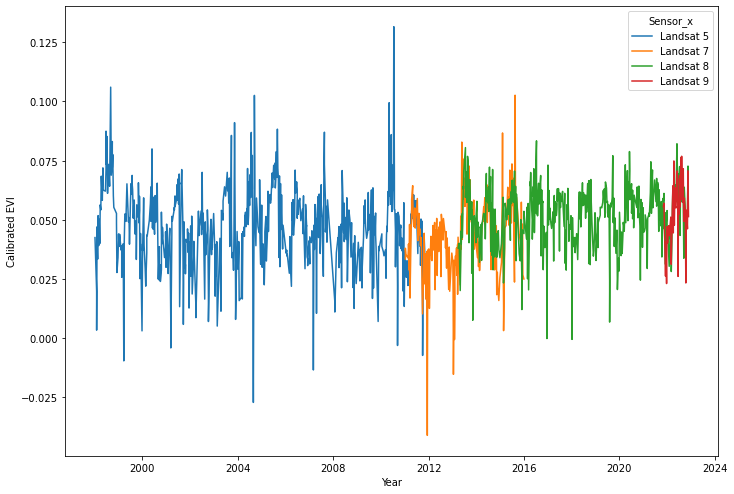

In [68]:
#Plotting evi
import seaborn as sns
import matplotlib.pyplot as plt

df = flats_series.copy()
df.reset_index(inplace=True, drop=True)
df = df[df['evi'].notna()]
df['caldiff'] = df['evi'] - df['evi_cal']

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
g = sns.lineplot(ax = ax, x = "date", y = "evi_cal", hue = "Sensor_x", data = df)
g.set(xlabel ="Year", ylabel = "Calibrated EVI")

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Calibrated NDWI')]

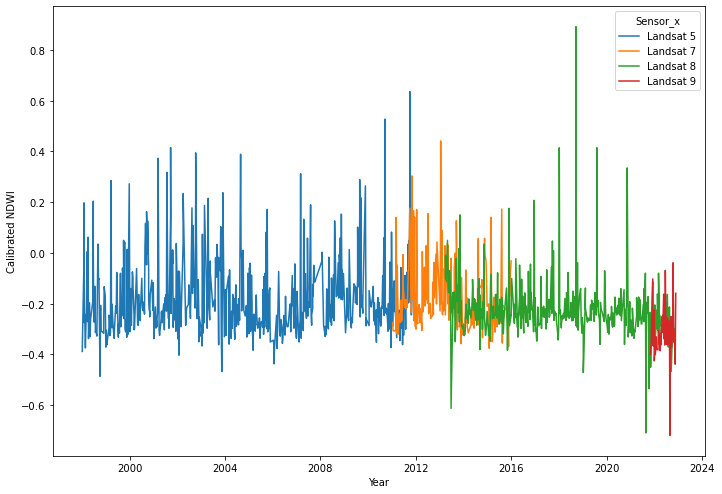

In [66]:
#Plotting ndwi
df = flats_series.copy()
df.reset_index(inplace=True, drop=True)
df = df[df['ndwi_cal'] > -1] #Removing some outliers
df = df[df['ndwi'].notna()]

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
g = sns.lineplot(ax = ax, x = "date", y = "ndwi_cal", hue = "Sensor_x", data = df)
g.set(xlabel ="Year", ylabel = "Calibrated NDWI")

In [36]:
'''
from: 
https://stackoverflow.com/questions/41962022/apply-function-to-dataframe-column-element-based-on-value-in-other-column-for-sa
https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o


def evifunc(evi, sensor):
    if flats_series['Sensor_x'] == 'Landsat 5':
        multiplier = {}
        return evi * 0.991 - 0.0014
    if flats_series['Sensor_x'] == 'Landsat 7':
        return evi * 1 
    if flats_series['Sensor_x'] == 'Landsat 8':
        return evi * 0.771 + 0.011    
    if flats_series['Sensor_x'] == 'Landsat 9':
        return evi * 0.974 - 0.0005    
    
def evifunc(evi, sensor):
        multiplier = {'Landsat 5':0.991, 'Landsat 7':1, 'Landsat 8':0.771, 'Landsat 9':0.974}
        constant = {'Landsat 5':-0.0014, 'Landsat 7':0, 'Landsat 8':0.011, 'Landsat 9':-0.0005}
        return evi * multiplier[sensor] + constant[sensor]
    
def ndwifunc(ndwi, sensor):
    if flats_series['Sensor_x'] == 'Landsat 5':
        return ndwi * 0.972 - 0.008
    if flats_series['Sensor_x'] == 'Landsat 7':
        return ndwi * 1 
    if flats_series['Sensor_x'] == 'Landsat 8':
        return ndwi * 0.841 - 0.019    
    if flats_series['Sensor_x'] == 'Landsat 9':
        return ndwi * 0.945 - 0.055 
    
def evifunc(evi, sensor):
        multiplier = {'Landsat 5':0.972, 'Landsat 7':1, 'Landsat 8':0.841, 'Landsat 9':0.945}
        constant = {'Landsat 5':-0.008, 'Landsat 7':0, 'Landsat 8':-0.019, 'Landsat 9':-0.055}
        return evi * multiplier[sensor] + constant[sensor]

flats_series['evi_cal'] = flats_series.apply(lambda x: evifunc(x['evi'], x['Sensor_x']), axis=1)
flats_series['ndwi_cal'] = flats_series.apply(lambda x: ndwifunc(x['ndwi'], x['Sensor_x']), axis=1)

flats_series'''

"\nfrom: \nhttps://stackoverflow.com/questions/41962022/apply-function-to-dataframe-column-element-based-on-value-in-other-column-for-sa\nhttps://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o\n\n\ndef evifunc(evi, sensor):\n    if flats_series['Sensor_x'] == 'Landsat 5':\n        multiplier = {}\n        return evi * 0.991 - 0.0014\n    if flats_series['Sensor_x'] == 'Landsat 7':\n        return evi * 1 \n    if flats_series['Sensor_x'] == 'Landsat 8':\n        return evi * 0.771 + 0.011    \n    if flats_series['Sensor_x'] == 'Landsat 9':\n        return evi * 0.974 - 0.0005    \n    \ndef evifunc(evi, sensor):\n        multiplier = {'Landsat 5':0.991, 'Landsat 7':1, 'Landsat 8':0.771, 'Landsat 9':0.974}\n        constant = {'Landsat 5':-0.0014, 'Landsat 7':0, 'Landsat 8':0.011, 'Landsat 9':-0.0005}\n        return evi * multiplier[sensor] + constant[sensor]\n    \ndef ndwifunc(ndwi, sensor):\n    if flats_series['S

In [31]:
##Exporting

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'flatsseries.csv')

# flats_series.to_csv(out_csv)

In [30]:
#Fin

1695